# Estimating uncertainty in abundance and propagating it to division and carbon loss rate estimates

### some preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20

In [2]:
zinser_sizedist = os.path.join(os.path.join('..', 'data', 'size_distribution', 'zinser_processed.nc'))

zinser_fig3 = pd.read_csv(os.path.join('..', 'data', 'ground_truth', 'zinser_figure3.csv'))
zinser_fig2a = pd.read_csv(os.path.join('..', 'data', 'ground_truth', 'zinser_figure2a.csv'))

# create a new data file and overwrite existing one
save_data = False

filename_save = os.path.join('..', 'data', 'rate_estimates', 'rate_estimates.nc')

zinser_fig2a

,exper time,cells A,cells B,FALS,time of day
0,0,6.346000e+07,6.503348e+07,0.1838,8
1,2,6.821390e+07,6.512750e+07,0.2147,10
2,4,6.871540e+07,6.523250e+07,0.2640,12
3,6,6.129510e+07,6.298554e+07,0.3314,14
4,8,6.547930e+07,6.597570e+07,0.3950,16
5,10,6.468750e+07,6.559250e+07,0.4416,18
6,12,7.017000e+07,7.009750e+07,0.4033,20
7,14,7.907500e+07,8.327500e+07,0.3108,22
8,16,8.929500e+07,9.382750e+07,0.2448,0
9,18,1.049125e+08,1.045200e+08,0.2020,2


# abundance

### compute average squared deviation from the mean

The original data above contains two meansurements of cell abundance at each time point. Based on prior knowledge and assumptions of the user that can be modified below.

Options that can be set by the user:
 * `correct_abundance_mean` will correct the estimate of the mean, so that it is not permitted to decrease with time
 * `scale_error_with_signal` assumes that the deviation from the mean scales (linearly) with the signal
 * use `sample_numavg` samples from `abundance_sample` to create `abundance_mean_sample`

In [3]:
correct_abundance_mean = True
scale_error_with_signal = True
num_samples = 10_000
sample_numavg = 2

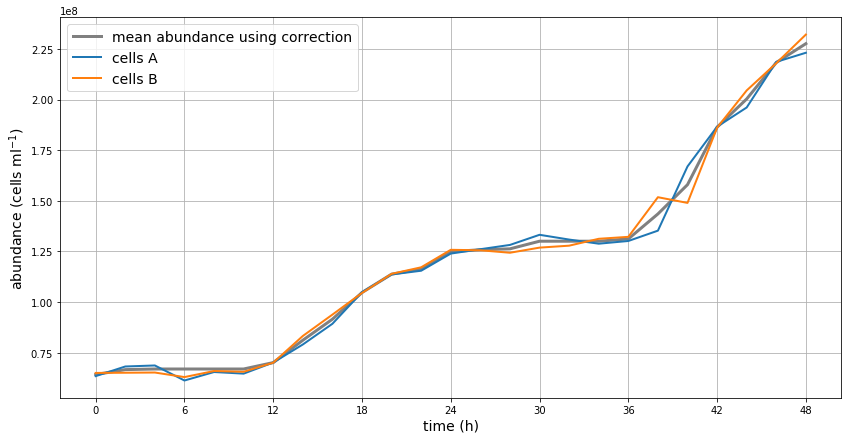

In [4]:
abundance_mean = 0.5 * (zinser_fig2a['cells A'].values + zinser_fig2a['cells B'].values)

if correct_abundance_mean:
    for i in range(1, abundance_mean.size):
        abundance_mean[i] = max(abundance_mean[i-1], abundance_mean[i])

obs_time_hours = zinser_fig2a['exper time'].values        

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, abundance_mean, label='mean abundance'+('',' using correction')[correct_abundance_mean], lw=3, color='0.5')
ax.plot(obs_time_hours, zinser_fig2a['cells A'], label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B'], label='cells B', lw=2)
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), ylabel='abundance (cells ml$^{-1}$)')
ax.legend()
ax.grid(True)

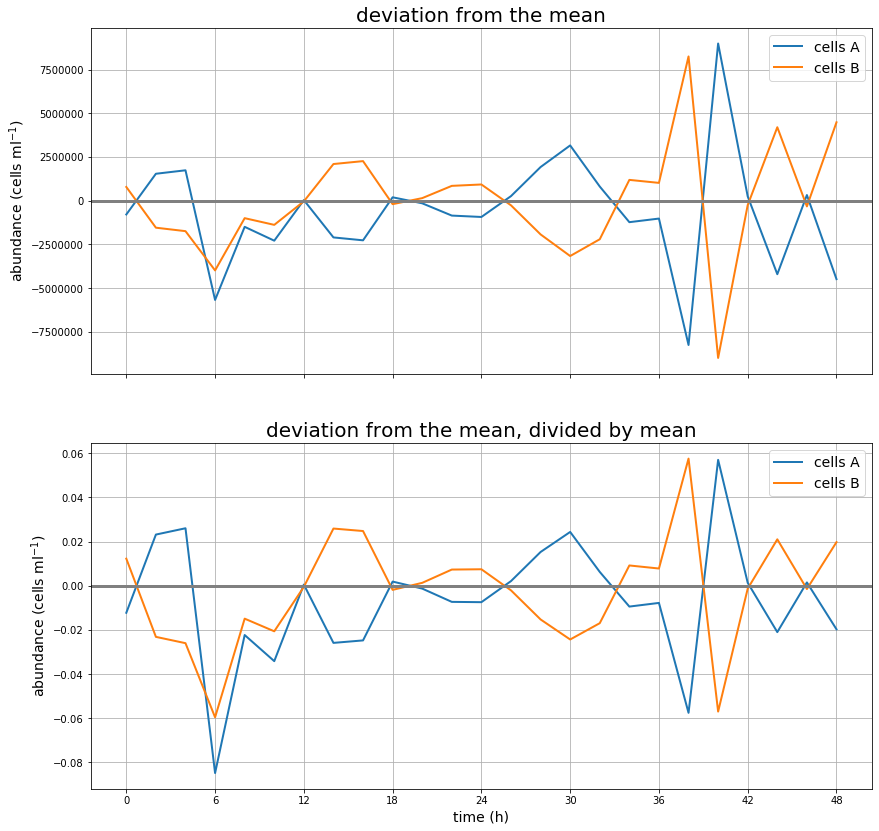

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(14,2*7), sharex=True)
ax = axs[0]
ax.set(title='deviation from the mean', ylabel='abundance (cells ml$^{-1}$)')
ax.plot(obs_time_hours, zinser_fig2a['cells A']-abundance_mean, label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B']-abundance_mean, label='cells B', lw=2)

ax = axs[1]
ax.set_title('deviation from the mean, divided by mean')
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), ylabel='abundance (cells ml$^{-1}$)')
ax.plot(obs_time_hours, (zinser_fig2a['cells A']-abundance_mean)/abundance_mean, label='cells A', lw=2)
ax.plot(obs_time_hours, (zinser_fig2a['cells B']-abundance_mean)/abundance_mean, label='cells B', lw=2)

for ax in axs:
    ax.axhline(0.0, lw=3, color='0.5')
    ax.legend()
    ax.grid(True)
None

In [6]:
diff_a = zinser_fig2a['cells A'] - abundance_mean
diff_b = zinser_fig2a['cells B'] - abundance_mean

if scale_error_with_signal:
    diff_a /= abundance_mean
    diff_b /= abundance_mean

sd_abundance = np.sqrt((np.sum(diff_a**2) + np.sum(diff_b**2))/(2 * diff_a.size - 1))

if scale_error_with_signal:
    sd_abundance *= abundance_mean

In [7]:
abundance_sample = abundance_mean + sd_abundance * np.random.normal(size=(sample_numavg, 
                                                                          num_samples, 
                                                                          abundance_mean.size))
abundance_mean_sample = np.mean(abundance_sample, axis=0)

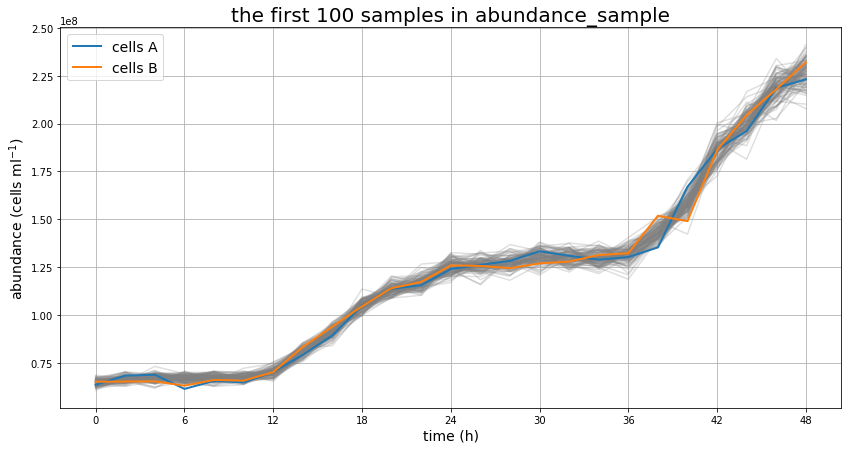

In [8]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, abundance_sample[0,:100,:].T, color='0.5', alpha=0.25)
ax.plot(obs_time_hours, zinser_fig2a['cells A'], label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B'], label='cells B', lw=2)

ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), ylabel='abundance (cells ml$^{-1}$)')
ax.legend()
ax.grid(True)
ax.set_title('the first 100 samples in abundance_sample')
None

# division

### average daily division rate

In [9]:
def compute_dailydiv(abundance, num_days=2):
    return np.log(abundance[...,-1] / abundance[...,0]) / num_days

for iday in range(2):
    i0 = iday * 12
    i1 = (iday + 1) * 12 + 1
    daily_division_sample = compute_dailydiv(abundance_mean_sample[:,i0:i1], num_days=1)
    print('''
daily division rate day {}:
   cells A: {:.3f}
   cells B: {:.3f}
      mean: {:.3f}
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
        iday + 1,
        compute_dailydiv(zinser_fig2a['cells A'].values[i0:i1], num_days=1),
        compute_dailydiv(zinser_fig2a['cells B'].values[i0:i1], num_days=1),
        compute_dailydiv(abundance_mean[i0:i1], num_days=1),
        np.mean(daily_division_sample), np.std(daily_division_sample)))

daily_division_sample = compute_dailydiv(abundance_mean_sample)

print('''
average daily division rate:
   cells A: {:.3f}
   cells B: {:.3f}
      mean: {:.3f}
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
    compute_dailydiv(zinser_fig2a['cells A'].values),
    compute_dailydiv(zinser_fig2a['cells B'].values),
    compute_dailydiv(abundance_mean),
    np.mean(daily_division_sample), np.std(daily_division_sample)))


daily division rate day 1:
   cells A: 0.669
   cells B: 0.660
      mean: 0.665
    sample: 0.665 ± 0.027 (mean ± sd)

daily division rate day 2:
   cells A: 0.588
   cells B: 0.612
      mean: 0.600
    sample: 0.600 ± 0.027 (mean ± sd)

average daily division rate:
   cells A: 0.629
   cells B: 0.636
      mean: 0.632
    sample: 0.632 ± 0.013 (mean ± sd)


### hourly division

In [10]:
def compute_hourly_div(abundance):
    return np.log(abundance[...,1:] / abundance[...,:-1]) / (obs_time_hours[1:] - obs_time_hours[:-1])

division_cellsA = compute_hourly_div(zinser_fig2a['cells A'].values)
division_cellsB = compute_hourly_div(zinser_fig2a['cells B'].values)
division_mean = compute_hourly_div(abundance_mean)

division_sample = compute_hourly_div(abundance_mean_sample)

obs_time_division = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

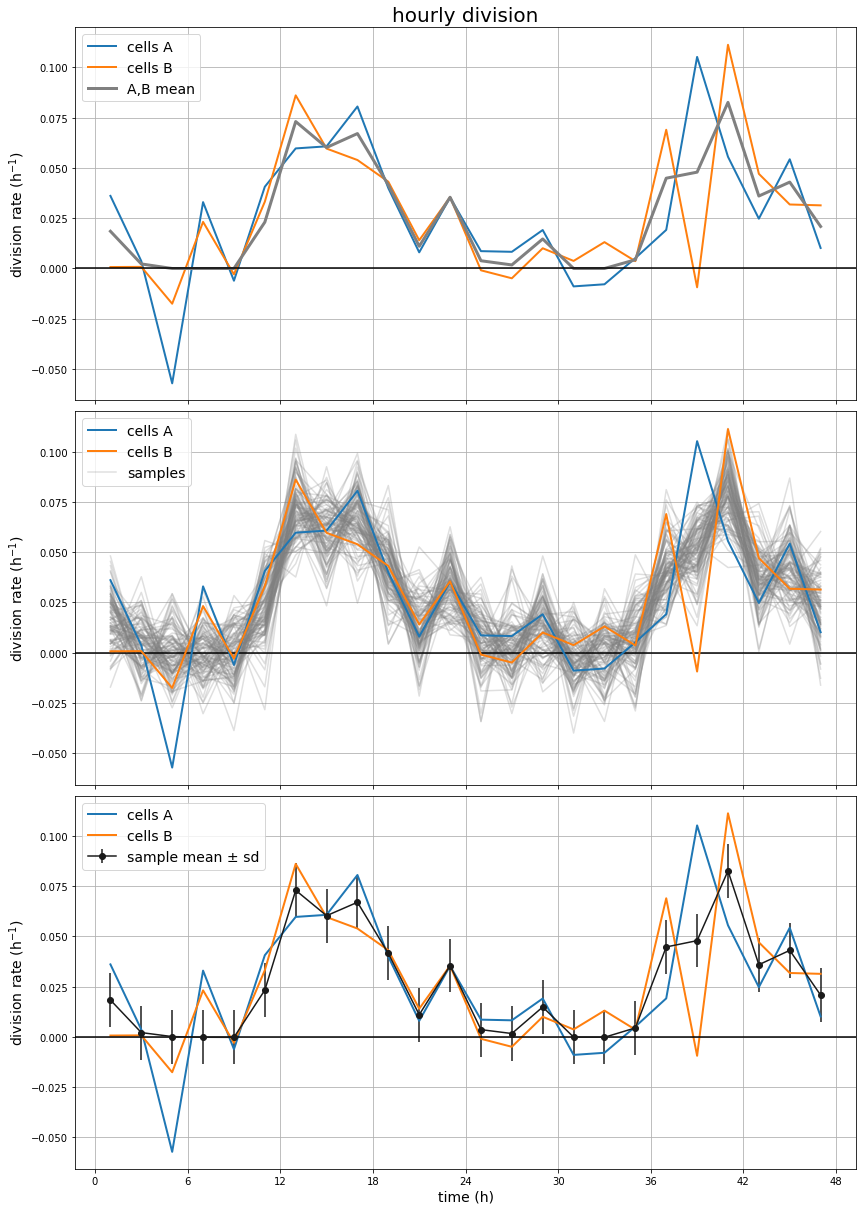

In [11]:
fig, axs = plt.subplots(nrows=3, figsize=(14,3*7), sharex=True, sharey=True, gridspec_kw={'hspace':0.03})
ax = axs[0]
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2)
ax.plot(obs_time_division, division_mean, label='A,B mean', lw=3, color='0.5')
ax.set_title('hourly division')

ax = axs[1]
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2, zorder=4)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2, zorder=4)
ax.plot(obs_time_division, division_sample[0,:].T, label='samples', color='0.5', alpha=0.25)
ax.plot(obs_time_division, division_sample[1:100,:].T, color='0.5', alpha=0.25)

ax = axs[2]
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6))
ax.errorbar(obs_time_division, np.mean(division_sample, axis=0), yerr=np.std(division_sample, axis=0), 
            marker='o', color='0.1', label='sample mean ± sd')
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2)

for ax in axs:
    ax.axhline(0, color='black')
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set(ylabel='division rate (h$^{-1}$)')

# carbon fixation

Carbon fixation values are included in the data along with standard deviation values (`PP` and `PP-sd`, respectively).

In [12]:
correct_negative_pp = True

In [13]:
pp = zinser_fig3['PP'].values

if correct_negative_pp:
    pp = np.maximum(pp, 0.0)

obs_time_fix = obs_time_hours + 1.0
pp_sample = pp + zinser_fig3['PP-sd'].values[None,:] * np.random.normal(size=(num_samples, obs_time_fix.size))

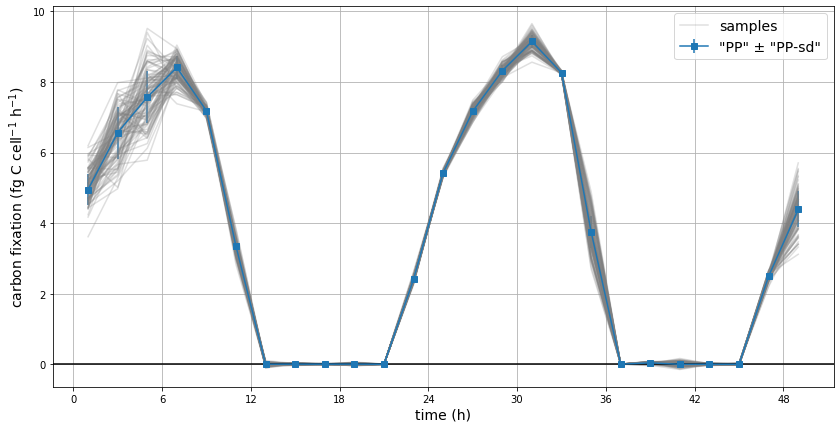

In [14]:
fig, ax = plt.subplots(figsize=(14,7))
ax.errorbar(obs_time_fix, pp, yerr=zinser_fig3['PP-sd'].values, label='"PP" ± "PP-sd"', 
            marker='s')
ax.plot(obs_time_fix, pp_sample[0,:].T, color='0.5', alpha=0.25, label='samples')
ax.plot(obs_time_fix, pp_sample[1:100,:].T, color='0.5', alpha=0.25)

ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), ylabel='carbon fixation (fg C cell$^{-1}$ h$^{-1}$)')
ax.axhline(0, color='black')
ax.legend()
ax.grid(True)
None

### average daily carbon fixation

In [15]:
def compute_intfix(fix, time_hours):
    td = np.diff(time_hours)
    return 0.5 * np.sum(td * (fix[...,1:] + fix[...,:-1]), axis=-1) 

#for sample, desc in ((pp_sample_reportedsd, 'reported standard deviation'), (pp_sample,'updated standard deviation')):

for iday in range(2):
    i0 = iday * 12
    i1 = (iday + 1) * 12 + 1
    daily_intfix = compute_intfix(pp_sample[:,i0:i1], obs_time_fix[i0:i1])
    print('''
carbon fixation day {} (fg C /cell /d):
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(iday + 1, np.mean(daily_intfix), np.std(daily_intfix)))

daily_intfix = 0.5 * compute_intfix(pp_sample, obs_time_fix)

print('''
avg daily carbon fixation (fg C /cell /d):
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(np.mean(daily_intfix), np.std(daily_intfix)))

# to be used later
daily_intfix = 0.5 * compute_intfix(pp_sample, obs_time_fix)


carbon fixation day 1 (fg C /cell /d):
    sample: 81.344 ± 2.304 (mean ± sd)

carbon fixation day 2 (fg C /cell /d):
    sample: 88.177 ± 1.210 (mean ± sd)

avg daily carbon fixation (fg C /cell /d):
    sample: 84.761 ± 1.294 (mean ± sd)


# carbon loss

### hourly carbon loss

In [16]:
# obtain more data
with nc4.Dataset(zinser_sizedist) as nc:
    w_obs = nc.variables['w_obs'][:]
    delta_v = 1.0/nc.variables['delta_v_inv'][:]
    v = nc.variables['v_min'][:].data * 2**(np.arange(nc.variables['m'][:])*delta_v)

Using the 2-hourly cell abundance measurements ($a_t$), average cell size measurements ($s_t$) and approximate carbon fixation rates ($f_t$), we then estimate carbon loss rates ($l_t$) every 2 hours, using
$$
s_{t+1} = s_{t} \;\frac{a_{t}}{a_{t+1}} + dt \; (f_{t} - l_{t}),
$$
where $dt$ is the two hour time step between measurements.

In [17]:
dt = obs_time_hours[1] - obs_time_hours[0]

cellsize = np.sum(v[:,None] * w_obs, axis=0)
net = (cellsize[1:]*(abundance_mean[1:]/abundance_mean[:-1]) - cellsize[:-1])/dt
loss = zinser_fig3['PP'].values[:-1] - net

obs_time_loss = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

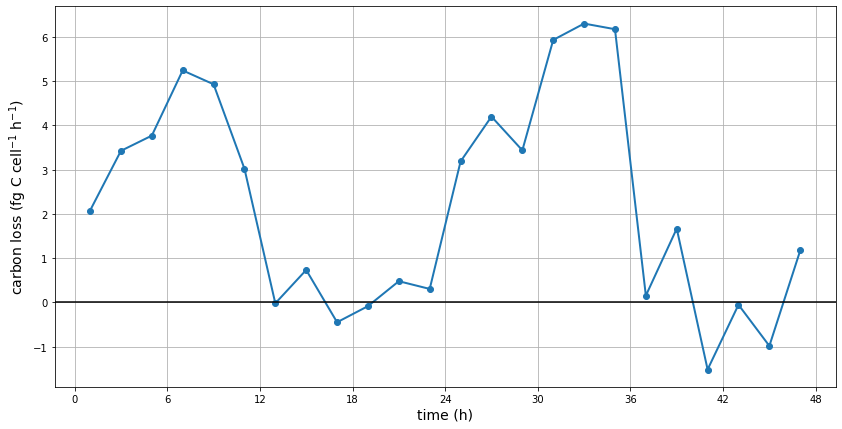

In [18]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_loss, loss, lw=2, marker='o')
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), ylabel='carbon loss (fg C cell$^{-1}$ h$^{-1}$)')
ax.grid(True)
ax.axhline(0, color='black')
None

### propagate uncertainty using the samples

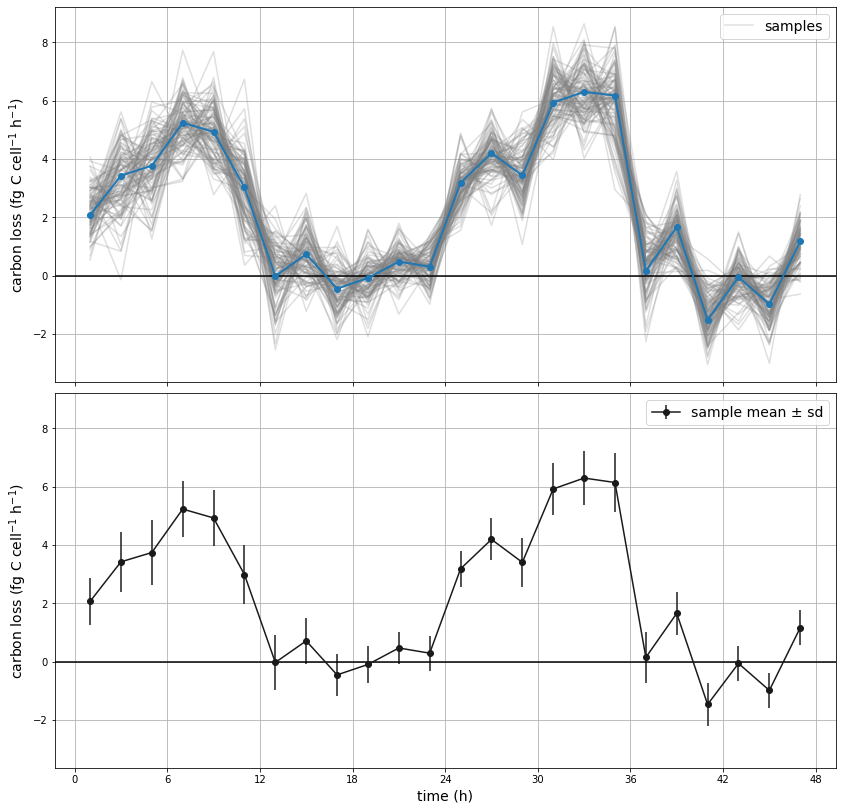

In [19]:

# compute net growth
cellsize = np.sum(v[:,None] * w_obs, axis=0)[None,:]
net = (cellsize[:,1:] * (abundance_mean_sample[:,1:]/abundance_mean_sample[:,:-1]) - cellsize[:,:-1])/dt

pp = pp_sample[:,:-1]

# combine
loss_sample = pp - net

fig, axs = plt.subplots(nrows=2, figsize=(14,2*7), sharex=True, sharey=True, gridspec_kw={'hspace':0.03})

ax = axs[0]
ax.plot(obs_time_loss, loss, lw=2, marker='o', zorder=4)
ax.plot(obs_time_loss, loss_sample[0,:].T, color='0.5', alpha=0.25, label='samples')
ax.plot(obs_time_loss, loss_sample[1:100,:].T, color='0.5', alpha=0.25)

ax = axs[1]
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6))
ax.errorbar(obs_time_loss, np.mean(loss_sample, axis=0), yerr=np.std(loss_sample, axis=0), 
            marker='o', color='0.1', label='sample mean ± sd')

for ax in axs:
    ax.axhline(0, color='black')
    ax.legend()
    ax.grid(True)
    ax.set(ylabel='carbon loss (fg C cell$^{-1}$ h$^{-1}$)')

### average daily carbon loss

In [20]:
def compute_intloss(loss, time_hours):
    td = np.diff(time_hours)
    return 0.5 * np.sum(td * (loss[...,1:] + loss[...,:-1]), axis=-1) 

for iday in range(2):
    i0 = iday * 12
    i1 = (iday + 1) * 12 + 1
    daily_intloss = compute_intloss(loss_sample[:,i0:i1], obs_time_loss[i0:i1])
    print('''
carbon loss day {} (fg C /cell /d):
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
        iday + 1,
        np.mean(daily_intloss), np.std(daily_intloss)))

daily_intloss = 0.5 * compute_intloss(loss_sample, obs_time_loss)

print('''
avg daily carbon loss (fg C /cell /d):
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
    np.mean(daily_intloss), np.std(daily_intloss)))


carbon loss day 1 (fg C /cell /d):
    sample: 47.678 ± 2.509 (mean ± sd)

carbon loss day 2 (fg C /cell /d):
    sample: 54.863 ± 1.483 (mean ± sd)

avg daily carbon loss (fg C /cell /d):
    sample: 51.270 ± 1.377 (mean ± sd)


# save results to netCDF

In [21]:
import netCDF4 as nc4

if save_data:
    with nc4.Dataset(filename_save, 'w') as nc:
        # first save some global attributes
        nc.setncatts({
            'created_by':'create_rate_estimates.ipynb',
            'correct_abundance_mean':int(correct_abundance_mean),
            'scale_error_with_signal':int(scale_error_with_signal),
        })

        #
        # abundance
        #

        nc.createDimension('abundance_time', obs_time_hours.size)

        var = nc.createVariable('abundance_time', int, ('abundance_time',))
        var[:] = obs_time_hours
        var.units = 'hours since start of experiment'

        var = nc.createVariable('abundance', float, ('abundance_time',))
        var[:] = np.mean(abundance_mean_sample, axis=0)
        var.long_name = 'cell abundance'
        var.units = 'cells ml$^{-1}$'

        var = nc.createVariable('abundance_sd', float, ('abundance_time',))
        var[:] = np.std(abundance_mean_sample, axis=0)
        var.long_name = 'standard deviation of cell abundance'
        var.units = 'cells ml$^{-1}$'

        #
        # division
        #

        nc.createDimension('division_time', obs_time_division.size)

        var = nc.createVariable('division_time', int, ('division_time',))
        var[:] = obs_time_division.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('division', float, ('division_time',))
        var[:] = np.mean(division_sample, axis=0)
        var.long_name = 'cell division rate'
        var.units = 'h$^{-1}$'

        var = nc.createVariable('division_sd', float, ('division_time',))
        var[:] = np.std(division_sample, axis=0)
        var.long_name = 'standard deviation of cell division rate'
        var.units = 'h$^{-1}$'

        # daily

        var = nc.createVariable('dailydivision', float, fill_value=False)
        var[:] = np.mean(daily_division_sample)
        var.long_name = 'mean daily cell division rate'
        var.units = 'd$^{-1}$'

        var = nc.createVariable('dailydivision_sd', float, fill_value=False)
        var[:] = np.std(daily_division_sample)
        var.long_name = 'standard deviation of daily cell division rate'
        var.units = 'd$^{-1}$'

        #
        # carbon loss
        #

        nc.createDimension('carbonloss_time', obs_time_loss.size)

        var = nc.createVariable('carbonloss_time', int, ('carbonloss_time',))
        var[:] = obs_time_loss.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('carbonloss', float, ('carbonloss_time',))
        var[:] = np.mean(loss_sample, axis=0)
        var.long_name = 'cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        var = nc.createVariable('carbonloss_sd', float, ('carbonloss_time',))
        var[:] = np.std(loss_sample, axis=0)
        var.long_name = 'standard deviation of cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        # daily

        var = nc.createVariable('dailycarbonloss', float, fill_value=False)
        var[:] = np.mean(daily_intloss)
        var.long_name = 'mean daily cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        var = nc.createVariable('dailycarbonloss_sd', float, fill_value=False)
        var[:] = np.std(daily_intloss)
        var.long_name = 'standard deviation of daily cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        #
        # carbon fixation
        #

        nc.createDimension('carbonfix_time', obs_time_fix.size)

        var = nc.createVariable('carbonfix_time', int, ('carbonfix_time',))
        var[:] = obs_time_fix.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('carbonfix', float, ('carbonfix_time',))
        var[:] = np.mean(pp_sample, axis=0)
        var.long_name = 'cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        var = nc.createVariable('carbonfix_sd', float, ('carbonfix_time',))
        var[:] = np.std(pp_sample, axis=0)
        var.long_name = 'standard deviation of cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        # daily

        var = nc.createVariable('dailycarbonfix', float, fill_value=False)
        var[:] = np.mean(daily_intfix)
        var.long_name = 'mean daily cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        var = nc.createVariable('dailycarbonfix_sd', float, fill_value=False)
        var[:] = np.std(daily_intfix)
        var.long_name = 'standard deviation of daily cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'